##### Copyright 2025 Google LLC.

In [86]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 2D spatial understanding with Gemini

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

This notebook introduces object detection and spatial understanding with the Gemini API like in the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) and demonstrated in the [Building with Gemini 2.0: Spatial understanding](https://www.youtube.com/watch?v=-XmoDzDMqj4) video.

You'll learn how to use Gemini the same way as in the demo and perform object detection like this:
<img src="https://storage.googleapis.com/generativeai-downloads/images/cupcakes_with_bbox.png" />

There are many examples, including object detection with

* simply overlaying information
* searching within an image
* translating and understanding things in multiple languages
* using Gemini thinking abilities

**Note**

There's no "magical prompt". Feel free to experiment with different ones. You can use the dropdown to see different samples, but you can also write your own prompts. Also, you can try uploading your own images.

----

## Setup

### Install SDK

In [87]:
%pip install -U -q "google-genai>=1.16.0"

### Setup your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [88]:
from google.colab import userdata
import os

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key.

In [89]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Select and configure a model

Spatial understanding works best [Gemini 2.0 Flash model](https://ai.google.dev/gemini-api/docs/models/gemini-v2). It's even better with 2.5 models like `gemini-2.5-pro` but slightly slower as it's a [thinking](./Get_started_thinking.ipynb) model.

Some features, like segmentation, only works with 2.5 models.

The [Object detection](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/examples/Object_detection.ipynb) contains good examples of what previous models were able to do.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [90]:
model_name = "gemini-2.5-flash" # @param ["gemini-2.0-flash", "gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro","gemini-3-pro-preview"] {"allow-input":true}

### System instructions

 With the new SDK, the `system_instructions` and the `model` parameters must be passed in all `generate_content` calls, so let's save them to not have to type them all the time.

In [91]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
"""

In [92]:
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

The system instructions are mainly used to make the prompts shorter by not having to reapeat each time the format. They are also telling the model how to deal with similar objects which is a nice way to let it be creative.

The [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) is using a different strategy with no system instructions but a longer prompt. You can see their full prompts by clicking on the "show raw prompt" button on the right. There no optimal solution, experiment with diffrent strategies and find the one that suits your use-case the best.

It is also recommend to always disable the [thinking](./Get_started_thinking.ipynb), as so far it adds latency without improving the results.

### Import

Import all the necessary modules.

In [93]:
import google.generativeai as genai
from PIL import Image

import io
import os
import requests
from io import BytesIO

### Utils

Some scripts will be needed to draw the bounding boxes. Of course they are just examples and you are free to just write your own.

For example the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) uses HML to render the bounding boxes. You can find its code in the [Github repo](https://github.com/google-gemini/starter-applets/tree/main/spatial).

In [94]:
# @title Parsing JSON output
def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [95]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
!apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


### Get example images

In [96]:
# Load sample images
!wget https://storage.googleapis.com/generativeai-downloads/images/socks.jpg -O Socks.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/vegetables.jpg -O Vegetables.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Japanese_Bento.png -O Japanese_bento.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Cupcakes.jpg -O Cupcakes.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/origamis.jpg -O Origamis.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/fruits.jpg -O Fruits.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/cat.jpg -O Cat.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/pumpkins.jpg -O Pumpkins.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/breakfast.jpg -O Breakfast.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/bookshelf.jpg -O Bookshelf.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/spill.jpg -O Spill.jpg -q

## Overlaying Information

Let's start by loading an image, the origami one for example:

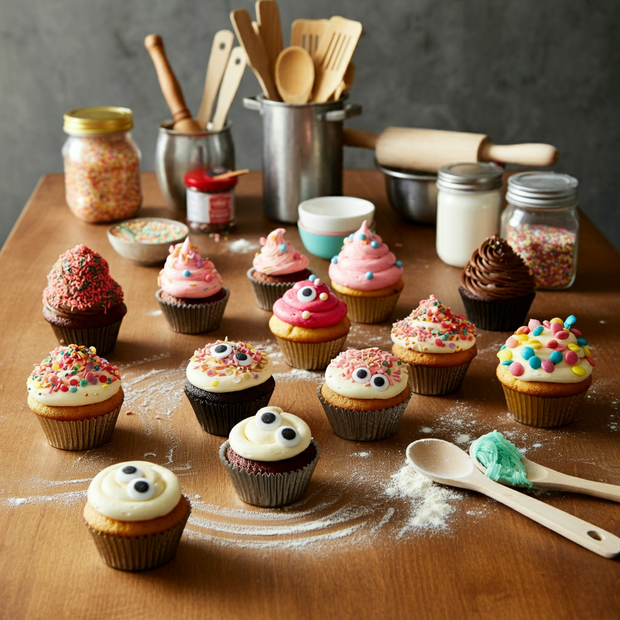

In [97]:
image = "Cupcakes.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}

im = Image.open(image)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

Let's start with a simple prompt to find all items in the image.

To prevent the model from repeating itself, it is recommended to use a temperature over 0, in this case 0.5. Limiting the number of items (25 in the systemp instructions) is also a way to prevent the model from looping and to speed up the decoding of the bounding boxes. You can experiment with these parameters and find what works best for your use-case.

It is also recommend to always disable the [thinking](./Get_started_thinking.ipynb), as so far it adds latency without improving the results.

In [98]:
prompt = "Detect the 2d bounding boxes of the cupcakes (with “label” as topping description”)"  # @param {type:"string"}

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Check output
print(response.text)

ServerError: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}

As you can see, even without any instructions about the format, Gemini is trained to always use this format with a label and the coordinates of the bounding box in a "box_2d" array.

Just be careful, the y coordinates are first, x ones afterwards contrary to common usage.

In [ ]:
plot_bounding_boxes(im, response.text)
im

## Search within an image

Let's complicate things and search within the image for specific objects.

In [ ]:
image = "Socks.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Show me the positions of the socks with the face"  # @param ["Detect all rainbow socks", "Find all socks and label them with emojis ", "Show me the positions of the socks with the face","Find the sock that goes with the one at the top"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Check output
print(response.text)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

Try it with different images and prompts. Different samples are proposed but you can also write your own.

## Multilinguality

As Gemini is able to understand multiple languages, you can combine spatial reasoning with multilingual capabilities.

You can give it an image like this and prompt it to label each item with Japanese characters and English translation. The model reads the text and recognize the pictures from the image itself and translates them.

In [ ]:
image = "Japanese_bento.png" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Detect food, label them with Japanese characters + english translation."  # @param ["Detect food, label them with Japanese characters + english translation.", "Show me the vegan dishes","Explain what those dishes are with a 5 words description","Find the dishes with allergens and label them accordingly"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

## Use Gemini reasoning capabilities

The model can also reason based on the image, you can ask it about the positions of items, their utility, or, like in this example, to find the shadow of a speficic item.

In [ ]:
image = "Origamis.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Draw a square around the fox' shadow"  # @param ["Find the two origami animals.", "Where are the origamis' shadows?","Draw a square around the fox' shadow"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

You can also use Gemini knowledge to enhanced the labels returned. In this example Gemini will give you advice on how to fix your little mistake.

As you can see this time, you're only resizing the image to 1024px as it helps the model getting the bigger picture and give you advice. There's no clear rule about when to do it, experiment and find what works the best for you.

In [ ]:
image = "Spill.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Tell me how to clean my table with an explanation as label. Do not just label the items"  # @param ["Show me where my coffee was spilled.", "Tell me how to clean my table with an explanation as label. Do not just label the items","Draw a square around the fox' shadow"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

In [ ]:
response.text

And if you check the previous examples, the [Japanese food](#scrollTo=tvVSSr7z3uN4) one in particular, multiple other prompt samples are provided to experiment with Gemini reasoning capabilities.

## Experimental: Segmentation

*   列表项
*   列表项



2.5 models are also able to segment the image and not only draw a bounding box but to also provide a mask of the contour of the items. It's especially useful if you are planning on editing images like in the [Virtual try-on](../examples/Virtual_Try_On.ipynb) example.

In [ ]:
# @title Segmentation Utils

import dataclasses
import numpy as np
import base64

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
  # bounding box pixel coordinates (not normalized)
  y0: int # in [0..height - 1]
  x0: int # in [0..width - 1]
  y1: int # in [0..height - 1]
  x1: int # in [0..width - 1]
  mask: np.array # [img_height, img_width] with values 0..255
  label: str

def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> list[SegmentationMask]:
  items = json.loads(parse_json(predicted_str))
  masks = []
  for item in items:
    raw_box = item["box_2d"]
    abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
    abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
    abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
    abs_x1 = int(item["box_2d"][3] / 1000 * img_width)
    if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
      print("Invalid bounding box", item["box_2d"])
      continue
    label = item["label"]
    png_str = item["mask"]
    if not png_str.startswith("data:image/png;base64,"):
      print("Invalid mask")
      continue
    png_str = png_str.removeprefix("data:image/png;base64,")
    png_str = base64.b64decode(png_str)
    mask = Image.open(io.BytesIO(png_str))
    bbox_height = abs_y1 - abs_y0
    bbox_width = abs_x1 - abs_x0
    if bbox_height < 1 or bbox_width < 1:
      print("Invalid bounding box")
      continue
    mask = mask.resize((bbox_width, bbox_height), resample=Image.Resampling.BILINEAR)
    np_mask = np.zeros((img_height, img_width), dtype=np.uint8)
    np_mask[abs_y0:abs_y1, abs_x0:abs_x1] = mask
    masks.append(SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, np_mask, label))
  return masks

def overlay_mask_on_img(
    img: Image,
    mask: np.ndarray,
    color: str,
    alpha: float = 0.7
) -> Image.Image:
    """
    Overlays a single mask onto a PIL Image using a named color.

    The mask image defines the area to be colored. Non-zero pixels in the
    mask image are considered part of the area to overlay.

    Args:
        img: The base PIL Image object.
        mask: A PIL Image object representing the mask.
              Should have the same height and width as the img.
              Modes '1' (binary) or 'L' (grayscale) are typical, where
              non-zero pixels indicate the masked area.
        color: A standard color name string (e.g., 'red', 'blue', 'yellow').
        alpha: The alpha transparency level for the overlay (0.0 fully
               transparent, 1.0 fully opaque). Default is 0.7 (70%).

    Returns:
        A new PIL Image object (in RGBA mode) with the mask overlaid.

    Raises:
        ValueError: If color name is invalid, mask dimensions mismatch img
                    dimensions, or alpha is outside the 0.0-1.0 range.
    """
    if not (0.0 <= alpha <= 1.0):
        raise ValueError("Alpha must be between 0.0 and 1.0")

    # Convert the color name string to an RGB tuple
    try:
        color_rgb: Tuple[int, int, int] = ImageColor.getrgb(color)
    except ValueError as e:
        # Re-raise with a more informative message if color name is invalid
        raise ValueError(f"Invalid color name '{color}'. Supported names are typically HTML/CSS color names. Error: {e}")

    # Prepare the base image for alpha compositing
    img_rgba = img.convert("RGBA")
    width, height = img_rgba.size

    # Create the colored overlay layer
    # Calculate the RGBA tuple for the overlay color
    alpha_int = int(alpha * 255)
    overlay_color_rgba = color_rgb + (alpha_int,)

    # Create an RGBA layer (all zeros = transparent black)
    colored_mask_layer_np = np.zeros((height, width, 4), dtype=np.uint8)

    # Mask has values between 0 and 255, threshold at 127 to get binary mask.
    mask_np_logical = mask > 127

    # Apply the overlay color RGBA tuple where the mask is True
    colored_mask_layer_np[mask_np_logical] = overlay_color_rgba

    # Convert the NumPy layer back to a PIL Image
    colored_mask_layer_pil = Image.fromarray(colored_mask_layer_np, 'RGBA')

    # Composite the colored mask layer onto the base image
    result_img = Image.alpha_composite(img_rgba, colored_mask_layer_pil)

    return result_img

def plot_segmentation_masks(img: Image, segmentation_masks: list[SegmentationMask]):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img: The PIL.Image.
        segmentation_masks: A string encoding as JSON a list of segmentation masks containing the name of the object,
         their positions in normalized [y1 x1 y2 x2] format, and the png encoded segmentation mask.
    """
    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors
    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Do this in 3 passes to make sure the boxes and text are always visible.

    # Overlay the mask
    for i, mask in enumerate(segmentation_masks):
      color = colors[i % len(colors)]
      img = overlay_mask_on_img(img, mask.mask, color)

    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Draw the bounding boxes
    for i, mask in enumerate(segmentation_masks):
      color = colors[i % len(colors)]
      draw.rectangle(
          ((mask.x0, mask.y0), (mask.x1, mask.y1)), outline=color, width=4
      )

    # Draw the text labels
    for i, mask in enumerate(segmentation_masks):
      color = colors[i % len(colors)]
      if mask.label != "":
        draw.text((mask.x0 + 8, mask.y0 - 20), mask.label, fill=color, font=font)
    return img

In [ ]:
image = "Cupcakes.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Give the segmentation masks for the metal, wooden and glass small items (ignore the table). Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key \"box_2d\", the segmentation mask in key \"mask\", and the text label in the key \"label\". Use descriptive labels."  # @param {type:"string"}

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find segmentation masks
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Check output

print('model_name' + model_name)
print(response.text)

The model predicts a JSON list, where each item represents a segmentation mask. Each item has a bounding box ("`box_2d`") in the format `[y0, x0, y1, x1]` with normalized coordinates between 0 and 1000, a label ("`label`") that identifies the object, and lastly the segmentation mask inside the bounding box, as base64 encoded png.

To use the mask, first you need to do base64 decoding, and then loading this string as a png. This will give you a probability map with values between 0 and 255. The mask needs to be resized to match the bounding box dimensions, then you can apply your confidence threshold, e.g. binarizing at 127 for the midpoint. Finally, pad the mask into an array of the size of the full image.

All these steps are done by the the `parse_segmentation_masks` function provided earlier.

Ultimately, use the `plot_segmentation_masks` function to visualize the decoded masks by overlaying it on the image.

In [ ]:
segmentation_masks = parse_segmentation_masks(response.text, img_height=im.size[1], img_width=im.size[0])

In [ ]:
plot_segmentation_masks(im, segmentation_masks)

In [ ]:
# 1. 加载本地图片
# 图片已经在当前目录下了
part_image_path = 'resized_part.png'
sheet_image_path = 'resized_sheet.png'

print(f"正在加载图片...")
part_img = Image.open(BytesIO(open(part_image_path, "rb").read()))
sheet_img = Image.open(BytesIO(open(sheet_image_path, "rb").read()))

# 2. 定义排料的配置
# 关键：System Instruction 必须要求输出标准格式，这样 parse_segmentation_masks 才能识别
nesting_system_inst = """
You are an expert nesting engine.
Task: Place the Part (Image 2) onto the Material Sheet (Image 1).
Constraints:
1. No overlap with existing colored parts.
2. Maximize space usage.

Output Format:
Return a JSON array. Each item must have:
- "box_2d": [ymin, xmin, ymax, xmax] (Normalized 0-1000)
- "mask": "base64_string" (The segmentation mask of the part inside the bounding box),
- "label": "placed_part"
"""

prompt = """
Image 1: Material Sheet.
Image 2: New Part to be placed.

Find the best valid position for the Part on the Sheet.
"""

# 3. 调用 Gemini
print("正在请求 " + model_name + " 进行排料计算...")
# model_name = "gemini-2.5-pro"

response_2 = client.models.generate_content(
    model=model_name,
    contents=[prompt, sheet_img, part_img],
    config=types.GenerateContentConfig(
        system_instruction=nesting_system_inst,
        temperature=0.1,
        response_mime_type="application/json"
    )
)

print("原始响应:", response_2.text)

In [ ]:
import base64
import io
import json
from PIL import Image, ImageOps

# 1. 加载本地图片
part_image_path = 'resized_part.png'
sheet_image_path = 'resized_sheet.png'

print(f"正在加载图片...")
part_img = Image.open(part_image_path).convert("RGBA") # 确保是RGBA模式以获取透明度
sheet_img = Image.open(sheet_image_path).convert("RGB")

# 获取尺寸用于归一化计算
sheet_w, sheet_h = sheet_img.size

# 2. 定义排料的配置
# 关键修改：不再请求 "mask" 字符串，而是请求 "transformation" (变换参数)
nesting_system_inst = """
You are an expert nesting engine.
Task: Place the Part (Image 2) onto the Material Sheet (Image 1) to find the best valid position.

Constraints:
1. No overlap with existing colored parts on the sheet.
2. Maximize space usage (pack tightly).
3. Rotation is allowed (0, 90, 180, 270 degrees).

Output Format:
Return a JSON array. Each item must have:
- "position_norm": [y_center, x_center] (Normalized coordinates 0-1000 of the part's center on the sheet)
- "rotation": integer (The rotation angle applied to the part: 0, 90, 180, or 270)
- "confidence": float (0-1)
"""

prompt = """
Image 1: Material Sheet.
Image 2: New Part to be placed.

Analyze the shape of the Part and the available space on the Sheet.
Output the placement parameters.
"""

# 3. 调用 Gemini
print(f"正在请求 {model_name} 进行排料计算...")

response_3 = client.models.generate_content(
    model=model_name,
    contents=[prompt, sheet_img, part_img],
    config=types.GenerateContentConfig(
        system_instruction=nesting_system_inst,
        temperature=0.1,
        response_mime_type="application/json"
    )
)

print("原始响应:", response_3.text)

# 4. 本地重建 Mask (解决不规则形状的关键步骤)
def reconstruct_mask_base64(sheet_size, part_image, center_norm, rotation):
    """
    在本地根据AI的参数重建Mask
    """
    sheet_w, sheet_h = sheet_size
    y_norm, x_norm = center_norm

    # 1. 旋转零件
    # expand=True 确保旋转后不被裁剪，但这会改变图片尺寸，需根据中心点重新计算
    # 这里为了简单，假设围绕中心旋转且尺寸适应
    rotated_part = part_image.rotate(-rotation, expand=True)

    # 2. 计算粘贴位置 (从归一化中心 -> 像素左上角)
    part_w, part_h = rotated_part.size
    center_x = (x_norm / 1000) * sheet_w
    center_y = (y_norm / 1000) * sheet_h

    top_left_x = int(center_x - part_w / 2)
    top_left_y = int(center_y - part_h / 2)

    # 3. 创建一个空的 Mask 画布 (全黑)
    mask_canvas = Image.new('L', sheet_size, 0)

    # 4. 提取零件的 Alpha 通道作为 Mask
    # 如果零件图自带透明背景，Alpha 通道就是最完美的不规则 Mask
    if rotated_part.mode == 'RGBA':
        part_mask = rotated_part.split()[3] # 获取 Alpha 通道
    else:
        # 如果不是RGBA，假设非白色/非黑色部分是零件
        part_mask = ImageOps.invert(rotated_part.convert('L'))

    # 5. 将零件 Mask 粘贴到画布上的指定位置
    mask_canvas.paste(part_mask, (top_left_x, top_left_y), mask=part_mask)

    # 6. 转为 Base64
    buffered = io.BytesIO()
    mask_canvas.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8'), mask_canvas

# --- 解析与验证 ---
try:
    results = json.loads(response_3.text)

    for item in results:
        # 获取 AI 算出的参数
        pos = item['position_norm']
        rot = item['rotation']

        print(f"AI 决策: 位置={pos}, 旋转={rot}°")

        # 本地生成完美的不规则 Mask
        mask_b64, mask_img = reconstruct_mask_base64((sheet_w, sheet_h), part_img, pos, rot)

        print(f"生成的 Mask Base64 长度: {len(mask_b64)}")

        # 可视化验证：将 Mask 叠加到原图上看看对不对
        debug_img = sheet_img.copy()
        debug_img.paste(Image.new('RGB', debug_img.size, (255, 0, 0)), (0, 0), mask=mask_img)
        debug_img.show()

        # 这里的 mask_b64 就是你原本想要 API 直接输出的那个字符串
        # 但它的精度是像素级的，且完全符合不规则边缘

except Exception as e:
    print(f"处理出错: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
print(f'mask_b64:{mask_b64}')
# print(f'mask_b64:{mask_b64}')

In [ ]:
# --- 验证结果可视化代码 ---
import matplotlib.pyplot as plt
from IPython.display import display # 专门用于 Colab/Jupyter 显示

print(f"\n=== 开始可视化验证 ===")

# 1. 准备底图 (Sheet)
# 确保底图是 RGB 模式以便显示彩色
final_visual = sheet_img.copy().convert("RGB")
draw_final = ImageDraw.Draw(final_visual)

# 2. 将生成的 Mask 叠加显示
# mask_img 是我们刚才函数里生成的那个黑白遮罩图
# 我们将它变成半透明红色，覆盖在底图上，这样最直观
overlay = Image.new('RGBA', final_visual.size, (255, 0, 0, 0)) # 全透明层
overlay_draw = ImageDraw.Draw(overlay)

# 我们需要重新获取一次位置信息用于绘图 (使用最后一次循环的数据)
# 注意：这里假设 results 列表里至少有一个结果
if results:
    item = results[0]
    pos = item['position_norm']

    # 再次计算像素坐标用于画框 (为了人类视觉确认)
    sheet_w, sheet_h = sheet_img.size
    center_y, center_x = pos[0], pos[1] # 注意 AI 返回的是 [y, x]

    px_x = (center_x / 1000) * sheet_w
    px_y = (center_y / 1000) * sheet_h

    print(f"视觉中心点 (像素): x={px_x:.1f}, y={px_y:.1f}")

    # 在底图上画一个十字标记中心
    r = 10 # 十字半径
    draw_final.line([(px_x - r, px_y), (px_x + r, px_y)], fill="blue", width=3)
    draw_final.line([(px_x, px_y - r), (px_x, px_y + r)], fill="blue", width=3)

    # 3. 将生成的 Mask (mask_img) 贴上去变成红色
    # mask_img 中白色部分(255)是零件，黑色(0)是背景
    # 我们创建一个红色的矩形，然后用 mask_img 作为遮罩贴上去
    red_layer = Image.new('RGBA', final_visual.size, (255, 0, 0, 150)) # 半透明红
    final_visual.paste(red_layer, (0,0), mask=mask_img)

# --- 3种查看方式 ---

# 方式 A: 如果你在 Colab / Jupyter Notebook 中 (推荐)
try:
    print("尝试在 Notebook 中显示...")
    display(final_visual)
except:
    pass

# 方式 B: 保存到本地文件 (最稳妥)
output_filename = "nesting_result_check.png"
final_visual.save(output_filename)
print(f"结果已保存为文件: {output_filename} (请在左侧文件栏下载查看)")

# 方式 C: 使用 Matplotlib 显示 (通用性强)
try:
    plt.figure(figsize=(10, 10))
    plt.imshow(final_visual)
    plt.axis('off')
    plt.title(f"Result: Pos={pos}, Rot={item['rotation']}")
    plt.show()
except Exception as e:
    print("Matplotlib 显示跳过")

print("=== 验证结束 ===")

In [100]:
import base64
import io
import json
from PIL import Image, ImageOps, ImageDraw
import numpy as np
from IPython.display import display

# ==========================================
# 1. 图像处理工具函数
# ==========================================

def make_white_transparent(image, threshold=240):
    """
    简单处理：将白色背景转为透明。
    用于让红色的排料预览图只显示零件形状，而不是一个红色矩形。
    """
    img = image.convert("RGBA")
    data = np.array(img)

    # 提取 R, G, B 通道
    r, g, b, a = data.T

    # 识别白色区域 (R, G, B 都大于阈值)
    white_areas = (r >= threshold) & (g >= threshold) & (b >= threshold)

    # 将白色区域的 Alpha 通道设为 0 (透明)
    data[..., 3][white_areas.T] = 0

    return Image.fromarray(data)

def clamp_coordinates(sheet_size, part_size, center_pos, margin=0):
    """
    坐标安全锁：确保零件不越界
    """
    sheet_w, sheet_h = sheet_size
    part_w, part_h = part_size
    # 注意：这里输入的是 (x, y)
    center_x, center_y = center_pos

    half_w = part_w / 2
    half_h = part_h / 2

    # 1. 计算安全范围
    min_x = half_w + margin
    max_x = sheet_w - half_w - margin
    min_y = half_h + margin
    max_y = sheet_h - half_h - margin

    # 2. 修正 X 坐标
    if min_x > max_x:
        safe_x = sheet_w / 2 # 零件太大，强行居中
    else:
        safe_x = max(min_x, min(center_x, max_x))

    # 3. 修正 Y 坐标
    if min_y > max_y:
        safe_y = sheet_h / 2
    else:
        safe_y = max(min_y, min(center_y, max_y))

    # 检查是否触发了修正
    if int(safe_x) != int(center_x) or int(safe_y) != int(center_y):
        print(f"⚠️ 触发越界保护! 原始:({center_x:.0f},{center_y:.0f}) -> 修正:({safe_x:.0f},{safe_y:.0f})")

    return safe_x, safe_y

# ==========================================
# 2. 主流程
# ==========================================
part_image_path = 'resized_part.png'
sheet_image_path = 'resized_sheet.png'

# 加载图片
raw_part = Image.open(part_image_path)
sheet_img = Image.open(sheet_image_path).convert("RGB")
sheet_w, sheet_h = sheet_img.size

# 【修改点 1】不再进行复杂抠图，只做简单的"白变透"处理，
# 这样后续生成的红色遮罩就是齿轮形状，而不是方块。
part_img = make_white_transparent(raw_part)

# ==========================================
# 3. Prompt 优化：明确坐标系为 X, Y
# ==========================================
nesting_system_inst = """
You are an expert nesting engine.
Task: Place the Part (Image 2) onto the Material Sheet (Image 1).

Constraints:
1. The sheet has a black border. The part must be STRICTLY INSIDE the border.
2. NO overlap with existing colored parts on the sheet.
3. Coordinate system: 0.0-1.0 float normalized.
4. Origin (0,0) is TOP-LEFT.

Output Format (JSON):
[
  {
    "position_norm": [x_center, y_center],
    "rotation": 0,
    "confidence": 0.95
  }
]
Note: "position_norm" is [x, y], NOT [row, col].
"""

prompt = """
Image 1: Sheet with existing parts.
Image 2: New Gear Part to place.

Find a valid empty space (non-overlapping).
Ensure the WHOLE part stays inside the black frame.
"""

print(f"\n>>> 请求 AI 计算...")
try:
    # 假设您已经定义了 client 和 model_name
    response_2 = client.models.generate_content(
        model=model_name,
        contents=[prompt, sheet_img, part_img],
        config=types.GenerateContentConfig(
            system_instruction=nesting_system_inst,
            temperature=0.1,
            response_mime_type="application/json"
        )
    )

    print("AI 原始响应:", response_2.text)
    data = json.loads(response_2.text)

    if data:
        item = data[0]
        # 【修改点 2】明确解构 X 和 Y，避免混淆
        norm_x, norm_y = item['position_norm']
        rot = item['rotation']

        # --- 旋转零件 ---
        # expand=True 会改变图片尺寸，这对于不规则物体很重要
        rotated_part = part_img.rotate(-rot, expand=True)
        r_w, r_h = rotated_part.size

        # --- 还原为像素坐标 ---
        center_x_px = norm_x * sheet_w
        center_y_px = norm_y * sheet_h

        print(f"AI 建议坐标 (像素): X={center_x_px:.1f}, Y={center_y_px:.1f}")

        # --- 调用安全锁修正 ---
        safe_x, safe_y = clamp_coordinates(
            (sheet_w, sheet_h),
            (r_w, r_h),
            (center_x_px, center_y_px),
            margin=5
        )

        # 直接使用 AI 的原始坐标，不做任何限制
        # safe_x = center_x_px
        # safe_y = center_y_px

        # --- 计算左上角粘贴点 ---
        # PIL paste 需要的是左上角坐标，不是中心点
        paste_x = int(safe_x - r_w / 2)
        paste_y = int(safe_y - r_h / 2)

        # --- 可视化 ---
        final_visual = sheet_img.copy().convert("RGBA")

        # 获取 alpha 通道作为遮罩 (由 make_white_transparent 生成)
        part_mask = rotated_part.split()[3]

        # 创建一个纯红色的图层
        red_layer = Image.new("RGBA", rotated_part.size, (255, 0, 0, 180))

        # 使用 mask 将红色图层贴上去 (只贴有像素的部分)
        final_visual.paste(red_layer, (paste_x, paste_y), mask=part_mask)

        print("\n=== 最终修正后的排料效果 ===")
        display(final_visual)

        # --- 生成 Base64 ---
        # 创建一个全黑底图
        final_mask_canvas = Image.new('L', (sheet_w, sheet_h), 0)
        # 在指定位置贴上白色的 mask
        final_mask_canvas.paste(part_mask, (paste_x, paste_y), mask=part_mask)

        buffered = io.BytesIO()
        final_mask_canvas.save(buffered, format="PNG")
        b64_str = base64.b64encode(buffered.getvalue()).decode()
        print(f"最终 Base64 长度: {len(b64_str)}")

except Exception as e:
    import traceback
    traceback.print_exc()
    print(f"错误: {e}")


>>> 请求 AI 计算...
错误: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}


Traceback (most recent call last):
  File "/tmp/ipython-input-3066103641.py", line 117, in <cell line: 0>
    response_2 = client.models.generate_content(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/google/genai/models.py", line 5218, in generate_content
    response = self._generate_content(
               ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/google/genai/models.py", line 4000, in _generate_content
    response = self._api_client.request(
               ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/google/genai/_api_client.py", line 1388, in request
    response = self._request(http_request, http_options, stream=False)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/google/genai/_api_client.py", line 1224, in _request
    return self._retry(self._request_once, http_request, stream)  # type: ignore[no-

## Preliminary capabilities: pointing and 3D boxes

Pointing and 3D bounding boxes are experimental model capabilities. Check this [other notebook](../examples/Spatial_understanding_3d.ipynb) to get a sneak peek on those upcoming capabilities.

<a href="../examples/Spatial_understanding_3d.ipynb"><img src="https://storage.googleapis.com/generativeai-downloads/images/box_3d.png" height="400"/></a>

## What's next?

For a more end-to-end example, the code from the [AI Studio Spatial understanding example](https://aistudio.google.com/starter-apps/spatial)  is available on [Github](https://github.com/google-gemini/starter-applets/tree/main/spatial).

You'll also find multiple other examples of Gemini apabilities in the [quickstart folder](https://github.com/google-gemini/cookbook/tree/main/quickstarts/), in particular the [Live API](./Get_started_LiveAPI.ipynb) and the [video understanding](./Video_understanding.ipynb) one.

Related to image recognition and reasoning, [Market a jet backpack](../examples/Market_a_Jet_Backpack.ipynb) and [Guess the shape](../examples/Guess_the_shape.ipynb) examples are worth checking to continue your Gemini API discovery (Note: these examples still use the old SDK). And of course the [pointing and 3d boxes](../examples/Spatial_understanding_3d.ipynb) example referenced earlier.